# DF Construction and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json

### Helper functions

In [50]:
cong_reference = {113: '2012', 114: '2014', 115: '2016', 116: '2018'}

In [2]:
def party_code_to_letter(party_code):
    '''
    Convert a party code from Voteview into a letter for a party in recent history
    '''
    if party_code == 100:
        return 'D'
    if party_code == 200:
        return 'R'
    if party_code == 328:
        return 'I'
    else:
        return np.nan

In [3]:
def parse_senator_names(name, name_type):
    split_name = name.split(', ', 1)
    last_name = split_name[0].split(' ')[-1].capitalize()
    first_name = split_name[1].replace(',','').split(' ')[0].capitalize()
    
    indiv_nick_names = {'Durbin': 'Dick', 'Cochran': 'Thad'}
    
    if name_type == 'last':
        return last_name
    elif name_type == 'first':
        return first_name
    elif name_type == 'first_abbrev':
        if last_name in indiv_nick_names.keys():
            return indiv_nick_names[last_name][0]
        elif '(' in split_name[1]:
            return split_name[1][split_name[1].index('(')+1]
        else:
            return first_name[0]
    else:
        return np.nan

In [4]:
def parse_election_history_names(name, name_type):
    nickname_dict = {'Joe': 'Joseph',
                     'Chuck': 'Charles',
                     'Jim': 'James',
                     'Ben': 'Benjamin',
                     'Dave': 'David',
                     'Bob': 'Robert',
                     'J': 'James',
                     'Tom': 'Thomas',
                     'Pat': 'Patrick',
                     'Bernie': 'Bernard',
                     'Herb': 'Herbert',
                     'Russel': 'Russell',
                     'Jay': 'John',
                     'Al': 'Alan',
                     'Bill': 'William',
                     'Mich': 'Mitch',
                     'Kit': 'Christopher'}

    if name[0] == ' ':
        name = name[1:]
    if name[-1] == ' ':
        name = name[:-1]
    comma_removed = name.replace(',', '').replace('.', '')
    
    split_name = comma_removed.split(' ')
    
    if name_type == 'first':
        #if there's a nickname that needs to be used and revised for clarity
        for name_part in split_name:
            if '"' in name_part:
                alt_name = name_part.replace('"', '')
                if alt_name in nickname_dict.keys():
                    return nickname_dict[alt_name]
                else:
                    return alt_name
            if '(' in name_part:
                alt_name = name_part.replace('(', '').replace(')', '')
                if alt_name in nickname_dict.keys():
                    return nickname_dict[alt_name]
                else:
                    return alt_name
                
        #if the first name is just a letter, use the second name as primary        
        if len(split_name[0]) < 2:
            if split_name[1] in nickname_dict.keys():
                return nickname_dict[split_name[1]]
            else:
                return split_name[1]
        else:
            if split_name[0] in nickname_dict.keys():
                return nickname_dict[split_name[0]]
            else:
                return split_name[0]
                
    if name_type == 'last':
        if split_name[-1].upper() == 'JR' or split_name[-1].upper() == 'III' or split_name[-1].upper() == 'IV':
            return split_name[-2]
        else:
            return split_name[-1]

In [5]:
def clean_election_history_parties(party):
    if 'democ' in party or 'lieberman' in party:
        return 'D'
    if 'repub' in party:
        return 'R'
    if 'indep' in party:
        return 'I'
    else:
        return np.nan

### Making the DataFrame

In [6]:
start_congress = 113
current_congress = 116

In [7]:
#DataFrame for all votes case in 113th through current congress
votes_df = pd.DataFrame()
for i in range(start_congress, current_congress+1):
    temp_df = pd.read_csv('votes/S{}_votes.csv'.format(i))
    votes_df = pd.concat([votes_df, temp_df], ignore_index=True)
    
votes_df.drop('prob', axis=1, inplace=True)

#drop votes belonging to the vice president
votes_to_drop = votes_df[votes_df['icpsr'].isin([99911, 99912])].index
votes_df.drop(votes_to_drop, inplace=True)
        
display(votes_df.head())
display(votes_df.tail())
display(votes_df.info())

,congress,chamber,rollnumber,icpsr,cast_code
0,113,Senate,1,14009,1
1,113,Senate,1,14203,1
2,113,Senate,1,14226,1
3,113,Senate,1,14230,1
4,113,Senate,1,14307,1


,congress,chamber,rollnumber,icpsr,cast_code
227354,116,Senate,508,49300,1
227355,116,Senate,508,49308,1
227356,116,Senate,508,49703,1
227357,116,Senate,508,49706,1
227358,116,Senate,508,94659,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 226585 entries, 0 to 227358
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   congress    226585 non-null  int64 
 1   chamber     226585 non-null  object
 2   rollnumber  226585 non-null  int64 
 3   icpsr       226585 non-null  int64 
 4   cast_code   226585 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 10.4+ MB


None

In [8]:
#make DataFrame of all senators from starting congress to current congress
member_df = pd.DataFrame()
for i in range(start_congress, current_congress+1):
    temp_df = pd.read_csv('members/S{}_members.csv'.format(i))
    member_df = pd.concat([member_df, temp_df], ignore_index=True)

#get rid of presidents from senate list
president_indexes = member_df[member_df['chamber'] == 'President'].index.values
member_df.drop(president_indexes, inplace=True)

#change the party code to a letter (Republican - R, Democrat - D, Independent - I)
member_df['party'] = member_df['party_code'].apply(lambda x: party_code_to_letter(x))

#separate out last name, first name, and middle names/suffixes
member_df['last_name'] = member_df['bioname'].apply(lambda x: parse_senator_names(x, 'last'))
member_df['first_name'] = member_df['bioname'].apply(lambda x: parse_senator_names(x, 'first'))

#drop useless columns
cols_to_drop = ['chamber', 'state_icpsr', 'district_code', 'party_code', 'occupancy', 'last_means', 'died', 
                'nominate_log_likelihood', 'nominate_geo_mean_probability', 'nominate_number_of_votes',
                'nominate_number_of_errors', 'conditional', 'nokken_poole_dim1', 'nokken_poole_dim2']
member_df.drop(cols_to_drop, axis=1, inplace=True)


display(member_df.head())
display(member_df.tail())
display(member_df.info())

,congress,icpsr,state_abbrev,bioname,bioguide_id,born,nominate_dim1,nominate_dim2,party,last_name,first_name
1,113,49700,AL,"SESSIONS, Jefferson Beauregard III (Jeff)",S001141,1946,0.549,0.130,R,Sessions,Jefferson
2,113,94659,AL,"SHELBY, Richard C.",S000320,1934,0.428,0.514,R,Shelby,Richard
3,113,40300,AK,"MURKOWSKI, Lisa",M001153,1957,0.210,-0.289,R,Murkowski,Lisa
4,113,40900,AK,"BEGICH, Mark",B001265,1962,-0.235,0.150,D,Begich,Mark
5,113,15039,AZ,"McCAIN, John Sidney, III",M000303,1936,0.381,-0.626,R,Mccain,John


,congress,icpsr,state_abbrev,bioname,bioguide_id,born,nominate_dim1,nominate_dim2,party,last_name,first_name
408,116,40915,WV,"MANCHIN, Joe, III",M001183,1947,-0.055,0.444,D,Manchin,Joe
409,116,29940,WI,"BALDWIN, Tammy",B001230,1962,-0.498,-0.179,D,Baldwin,Tammy
410,116,41111,WI,"JOHNSON, Ron",J000293,1955,0.603,-0.288,R,Johnson,Ron
411,116,40707,WY,"BARRASSO, John A.",B001261,1952,0.539,0.237,R,Barrasso,John
412,116,49706,WY,"ENZI, Michael B.",E000285,1944,0.544,0.192,R,Enzi,Michael


<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 1 to 412
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   congress       411 non-null    int64  
 1   icpsr          411 non-null    int64  
 2   state_abbrev   411 non-null    object 
 3   bioname        411 non-null    object 
 4   bioguide_id    411 non-null    object 
 5   born           411 non-null    int64  
 6   nominate_dim1  411 non-null    float64
 7   nominate_dim2  411 non-null    float64
 8   party          411 non-null    object 
 9   last_name      411 non-null    object 
 10  first_name     411 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 38.5+ KB


None

In [11]:
votes_members_df = votes_df.merge(member_df, how='left', on=['congress', 'icpsr'])

display(votes_members_df.head())
display(votes_members_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,nominate_dim2,party,last_name,first_name
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,0.051,R,Cochran,William
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,0.017,D,Baucus,Max
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,-0.065,R,Grassley,Charles
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,-0.546,D,Harkin,Thomas
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,-0.129,D,Leahy,Patrick


<class 'pandas.core.frame.DataFrame'>
Int64Index: 226585 entries, 0 to 226584
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   congress       226585 non-null  int64  
 1   chamber        226585 non-null  object 
 2   rollnumber     226585 non-null  int64  
 3   icpsr          226585 non-null  int64  
 4   cast_code      226585 non-null  int64  
 5   state_abbrev   226585 non-null  object 
 6   bioname        226585 non-null  object 
 7   bioguide_id    226585 non-null  object 
 8   born           226585 non-null  int64  
 9   nominate_dim1  226585 non-null  float64
 10  nominate_dim2  226585 non-null  float64
 11  party          226585 non-null  object 
 12  last_name      226585 non-null  object 
 13  first_name     226585 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 25.9+ MB


None

In [12]:
#combine rollcall info for each congress into one DataFrame
rollcall_df = pd.DataFrame()
for i in range(start_congress, current_congress+1):
    temp_df = pd.read_csv('rollcalls/S{}_rollcalls.csv'.format(i))
    rollcall_df = pd.concat([rollcall_df, temp_df], ignore_index=True)
    
cols_to_drop = ['chamber', 'dtl_desc', 'clerk_rollnumber', 'nominate_mid_1', 'nominate_mid_2', 
                'nominate_spread_1', 'nominate_spread_2', 'nominate_log_likelihood']
rollcall_df.drop(cols_to_drop, axis=1, inplace=True)
    
display(rollcall_df.head())
display(rollcall_df.tail())
display(rollcall_df.info())

,congress,rollnumber,date,session,yea_count,nay_count,bill_number,vote_result,vote_desc,vote_question
0,113,1,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
1,113,2,2013-01-24,1,86,9,SRES16,Resolution Agreed to,A resolution amending the Standing Rules of th...,On the Resolution
2,113,3,2013-01-28,1,35,62,HR152,Amendment Rejected,To offset the cost of the bill with rescission...,On the Amendment
3,113,4,2013-01-28,1,63,36,HR152,Bill Passed,A bill making supplemental appropriations for ...,On Passage of the Bill
4,113,5,2013-01-29,1,95,3,PN42,Nomination Confirmed,"John Forbes Kerry, of Massachusetts, to be Sec...",On the Nomination


,congress,rollnumber,date,session,yea_count,nay_count,bill_number,vote_result,vote_desc,vote_question
2261,116,504,2020-03-18,2,90,8,HR6201,Bill Passed,A bill making emergency supplemental appropria...,On Passage of the Bill
2262,116,505,2020-03-22,2,47,47,HR748,Cloture on the Motion to Proceed Rejected,A bill to amend the Internal Revenue Code of 1...,On Cloture on the Motion to Proceed
2263,116,506,2020-03-23,2,49,46,HR748,Cloture on the Motion to Proceed Rejected,A bill to amend the Internal Revenue Code of 1...,On Cloture on the Motion to Proceed
2264,116,507,2020-03-25,2,48,48,HR748,Amendment Rejected,To ensure that additional unemployment benefit...,On the Amendment
2265,116,508,2020-03-25,2,96,0,HR748,Bill Passed,A bill to amend the Internal Revenue Code of 1...,On Passage of the Bill


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266 entries, 0 to 2265
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   congress       2266 non-null   int64 
 1   rollnumber     2266 non-null   int64 
 2   date           2266 non-null   object
 3   session        2266 non-null   int64 
 4   yea_count      2266 non-null   int64 
 5   nay_count      2266 non-null   int64 
 6   bill_number    2263 non-null   object
 7   vote_result    2266 non-null   object
 8   vote_desc      2263 non-null   object
 9   vote_question  2266 non-null   object
dtypes: int64(5), object(5)
memory usage: 177.2+ KB


None

## Combining and paring down votes on members on rollcalls

In [13]:
votes_members_rollcalls_df = votes_members_df.merge(rollcall_df, how='left', on=['congress', 'rollnumber'])

#eliminate items that don't have a bill number
votes_members_rollcalls_df.dropna(axis=0, subset=['bill_number'], inplace=True)

display(votes_members_rollcalls_df.head())
display(votes_members_rollcalls_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,last_name,first_name,date,session,yea_count,nay_count,bill_number,vote_result,vote_desc,vote_question
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Cochran,William,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,Baucus,Max,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,Grassley,Charles,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,Harkin,Thomas,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,Leahy,Patrick,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution


<class 'pandas.core.frame.DataFrame'>
Int64Index: 226285 entries, 0 to 226584
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   congress       226285 non-null  int64  
 1   chamber        226285 non-null  object 
 2   rollnumber     226285 non-null  int64  
 3   icpsr          226285 non-null  int64  
 4   cast_code      226285 non-null  int64  
 5   state_abbrev   226285 non-null  object 
 6   bioname        226285 non-null  object 
 7   bioguide_id    226285 non-null  object 
 8   born           226285 non-null  int64  
 9   nominate_dim1  226285 non-null  float64
 10  nominate_dim2  226285 non-null  float64
 11  party          226285 non-null  object 
 12  last_name      226285 non-null  object 
 13  first_name     226285 non-null  object 
 14  date           226285 non-null  object 
 15  session        226285 non-null  int64  
 16  yea_count      226285 non-null  int64  
 17  nay_count      226285 non-nul

None

In [14]:
#find all nomination votes and treaty votes to pull out from vote history
nomination_votes = votes_members_rollcalls_df[votes_members_rollcalls_df['bill_number'].str.contains('PN')]

treaty_votes = votes_members_rollcalls_df[votes_members_rollcalls_df['bill_number'].str.contains('TREATYDOC')]

votes_to_ignore = pd.concat([nomination_votes, treaty_votes])

votes_members_rollcalls_df.drop(votes_to_ignore.index, axis=0, inplace=True)

display(votes_members_rollcalls_df.head())
display(votes_members_rollcalls_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,last_name,first_name,date,session,yea_count,nay_count,bill_number,vote_result,vote_desc,vote_question
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Cochran,William,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,Baucus,Max,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,Grassley,Charles,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,Harkin,Thomas,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,Leahy,Patrick,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115694 entries, 0 to 226584
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   congress       115694 non-null  int64  
 1   chamber        115694 non-null  object 
 2   rollnumber     115694 non-null  int64  
 3   icpsr          115694 non-null  int64  
 4   cast_code      115694 non-null  int64  
 5   state_abbrev   115694 non-null  object 
 6   bioname        115694 non-null  object 
 7   bioguide_id    115694 non-null  object 
 8   born           115694 non-null  int64  
 9   nominate_dim1  115694 non-null  float64
 10  nominate_dim2  115694 non-null  float64
 11  party          115694 non-null  object 
 12  last_name      115694 non-null  object 
 13  first_name     115694 non-null  object 
 14  date           115694 non-null  object 
 15  session        115694 non-null  int64  
 16  yea_count      115694 non-null  int64  
 17  nay_count      115694 non-nul

None

In [15]:
id_ref_df = pd.read_csv('senator_id_reference_table.csv')

display(id_ref_df.head())
display(id_ref_df.tail())
display(id_ref_df.info())

,icpsr,state_abbrev,bioguide_id,party,last_name,first_name,cid,feccandid,alt_first_name
0,49700,AL,S001141,R,Sessions,Jefferson,N00003062,S6AL00195,Jeff
1,94659,AL,S000320,R,Shelby,Richard,N00009920,S6AL00013,Richard
2,40300,AK,M001153,R,Murkowski,Lisa,N00026050,S4AK00099,Lisa
3,40900,AK,B001265,D,Begich,Mark,N00029901,S8AK00090,Mark
4,15039,AZ,M000303,R,Mccain,John,N00006424,S6AZ00019,John


,icpsr,state_abbrev,bioguide_id,party,last_name,first_name,cid,feccandid,alt_first_name
135,41901,MO,H001089,R,Hawley,Joshua,N00041620,S8MO00160,Josh
136,21743,NV,R000608,D,Rosen,Jacklyn,N00038734,S8NV00156,Jacky
137,21350,ND,C001096,R,Cramer,Kevin,N00004614,S8ND00120,Kevin
138,20351,TN,B001243,R,Blackburn,Marsha,N00003105,S8TN00337,Marsha
139,41902,UT,R000615,R,Romney,Willard,N00000286,S8UT00176,Mitt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   icpsr           140 non-null    int64 
 1   state_abbrev    140 non-null    object
 2   bioguide_id     140 non-null    object
 3   party           140 non-null    object
 4   last_name       140 non-null    object
 5   first_name      140 non-null    object
 6   cid             139 non-null    object
 7   feccandid       138 non-null    object
 8   alt_first_name  140 non-null    object
dtypes: int64(1), object(8)
memory usage: 10.0+ KB


None

In [19]:
vmr_id_df = votes_members_rollcalls_df.merge(id_ref_df[['icpsr', 'cid']], how='left', on='icpsr')

#drops rows where Jeffrey Chiesa voted (because he only served a short term and has no contribution info)
chiesa_bioid = id_ref_df[id_ref_df['last_name'] == 'Chiesa'].bioguide_id.values[0]

chiesa_rows = vmr_id_df[vmr_id_df['bioguide_id'] == chiesa_bioid].index
vmr_id_df.drop(chiesa_rows, inplace=True)

display(vmr_id_df.head())
display(vmr_id_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,first_name,date,session,yea_count,nay_count,bill_number,vote_result,vote_desc,vote_question,cid
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,William,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution,N00003328
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,Max,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution,N00004643
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,Charles,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution,N00001758
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,Thomas,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution,N00004207
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,Patrick,2013-01-24,1,78,16,SRES15,Resolution Agreed to,A resolution to improve procedures for the con...,On the Resolution,N00009918


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115651 entries, 0 to 115693
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   congress       115651 non-null  int64  
 1   chamber        115651 non-null  object 
 2   rollnumber     115651 non-null  int64  
 3   icpsr          115651 non-null  int64  
 4   cast_code      115651 non-null  int64  
 5   state_abbrev   115651 non-null  object 
 6   bioname        115651 non-null  object 
 7   bioguide_id    115651 non-null  object 
 8   born           115651 non-null  int64  
 9   nominate_dim1  115651 non-null  float64
 10  nominate_dim2  115651 non-null  float64
 11  party          115651 non-null  object 
 12  last_name      115651 non-null  object 
 13  first_name     115651 non-null  object 
 14  date           115651 non-null  object 
 15  session        115651 non-null  int64  
 16  yea_count      115651 non-null  int64  
 17  nay_count      115651 non-nul

None

## Industries

In [20]:
cid_cong_to_search = []
for i in range(start_congress, current_congress+1):
    temp_cid = vmr_id_df[vmr_id_df['congress'] == i].cid.unique()
    temp_cong_cid = []
    for cid in temp_cid:
        temp_cong_cid.append([i, cid])
        
    cid_cong_to_search = cid_cong_to_search + temp_cong_cid

In [21]:
list_of_cid_industries = []

for cong,cid in cid_cong_to_search:
    try:
        with open('crp_jsons/{}_{}_industries.json'.format(cid, cong_reference[cong]), 'r') as f:
            data = json.load(f)
    except:
        data = {cid: 'No file'}

    industry_dict = {'cid': cid,
                     'cong': cong}
    
    for i in range(10):
        try:
            industry_dict.update({'Industry_{}'.format(i): data[i]['@attributes']['industry_name'],
                                  'Industry_{}_contrib'.format(i): data[i]['@attributes']['total']})
        except:
            industry_dict.update({'Industry_{}'.format(i): np.nan,
                                  'Industry_{}_contrib'.format(i): np.nan})

    list_of_cid_industries.append(industry_dict)
    
industry_info_df = pd.DataFrame(list_of_cid_industries)

display(industry_info_df.head())
display(industry_info_df.info())

,cid,cong,Industry_0,Industry_0_contrib,Industry_1,Industry_1_contrib,Industry_2,Industry_2_contrib,Industry_3,Industry_3_contrib,...,Industry_5,Industry_5_contrib,Industry_6,Industry_6_contrib,Industry_7,Industry_7_contrib,Industry_8,Industry_8_contrib,Industry_9,Industry_9_contrib
0,N00003328,113,Crop Production & Basic Processing,215844,Lawyers/Law Firms,208914,Lobbyists,118100,Agricultural Services/Products,96700,...,Oil & Gas,87156,Defense Aerospace,76800,Leadership PACs,71800,Real Estate,66560,Pharmaceuticals/Health Products,62000
1,N00004643,113,Securities & Investment,913269,Lawyers/Law Firms,680347,Insurance,611100,Lobbyists,583637,...,Health Services/HMOs,553218,Pharmaceuticals/Health Products,528432,Hospitals/Nursing Homes,458968,Real Estate,458830,Electric Utilities,287642
2,N00001758,113,Health Professionals,400970,Insurance,385202,Leadership PACs,311300,Lobbyists,299868,...,Pharmaceuticals/Health Products,219650,Lawyers/Law Firms,214173,Health Services/HMOs,214150,Retired,208157,Hospitals/Nursing Homes,204837
3,N00004207,113,Lawyers/Law Firms,571312,Health Professionals,523798,Lobbyists,406752,Securities & Investment,374730,...,Retired,288663,Hospitals/Nursing Homes,234500,Crop Production & Basic Processing,209235,Real Estate,203750,Insurance,183030
4,N00009918,113,Lawyers/Law Firms,639940,TV/Movies/Music,331606,Lobbyists,294400,Electronics Mfg & Equip,274211,...,Securities & Investment,128000,Public Sector Unions,94000,Retired,87100,Pro-Israel,76562,Real Estate,74900


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cid                 410 non-null    object
 1   cong                410 non-null    int64 
 2   Industry_0          400 non-null    object
 3   Industry_0_contrib  400 non-null    object
 4   Industry_1          400 non-null    object
 5   Industry_1_contrib  400 non-null    object
 6   Industry_2          400 non-null    object
 7   Industry_2_contrib  400 non-null    object
 8   Industry_3          400 non-null    object
 9   Industry_3_contrib  400 non-null    object
 10  Industry_4          400 non-null    object
 11  Industry_4_contrib  400 non-null    object
 12  Industry_5          400 non-null    object
 13  Industry_5_contrib  400 non-null    object
 14  Industry_6          400 non-null    object
 15  Industry_6_contrib  400 non-null    object
 16  Industry_7          400 no

None

In [22]:
industries = []
for i in range(10):
    temp_industry = industry_info_df['Industry_{}'.format(i)].unique()
    industries += list(temp_industry)
    
industries = [x for x in industries if pd.notna(x)]    
set(industries)

{'Abortion Policy/Pro-Abortion Rights',
 'Accountants',
 'Agricultural Services/Products',
 'Air Transport',
 'Automotive',
 'Building Materials & Equipment',
 'Building Trade Unions',
 'Business Services',
 'Candidate Committees',
 'Casinos/Gambling',
 'Chemical & Related Manufacturing',
 'Civil Servants/Public Officials',
 'Commercial Banks',
 'Construction Services',
 'Crop Production & Basic Processing',
 'Defense Aerospace',
 'Defense Electronics',
 'Democratic/Liberal',
 'Education',
 'Electric Utilities',
 'Electronics Mfg & Equip',
 'Environment',
 'Finance/Credit Companies',
 'Food & Beverage',
 'Food Processing & Sales',
 'General Contractors',
 'Health Professionals',
 'Health Services/HMOs',
 'Hospitals/Nursing Homes',
 'Human Rights',
 'Industrial Unions',
 'Insurance',
 'Lawyers/Law Firms',
 'Leadership PACs',
 'Livestock',
 'Lobbyists',
 'Mining',
 'Misc Business',
 'Misc Defense',
 'Misc Energy',
 'Misc Finance',
 'Misc Manufacturing & Distributing',
 'Misc Unions',
 'N

In [23]:
len(set(industries))

62

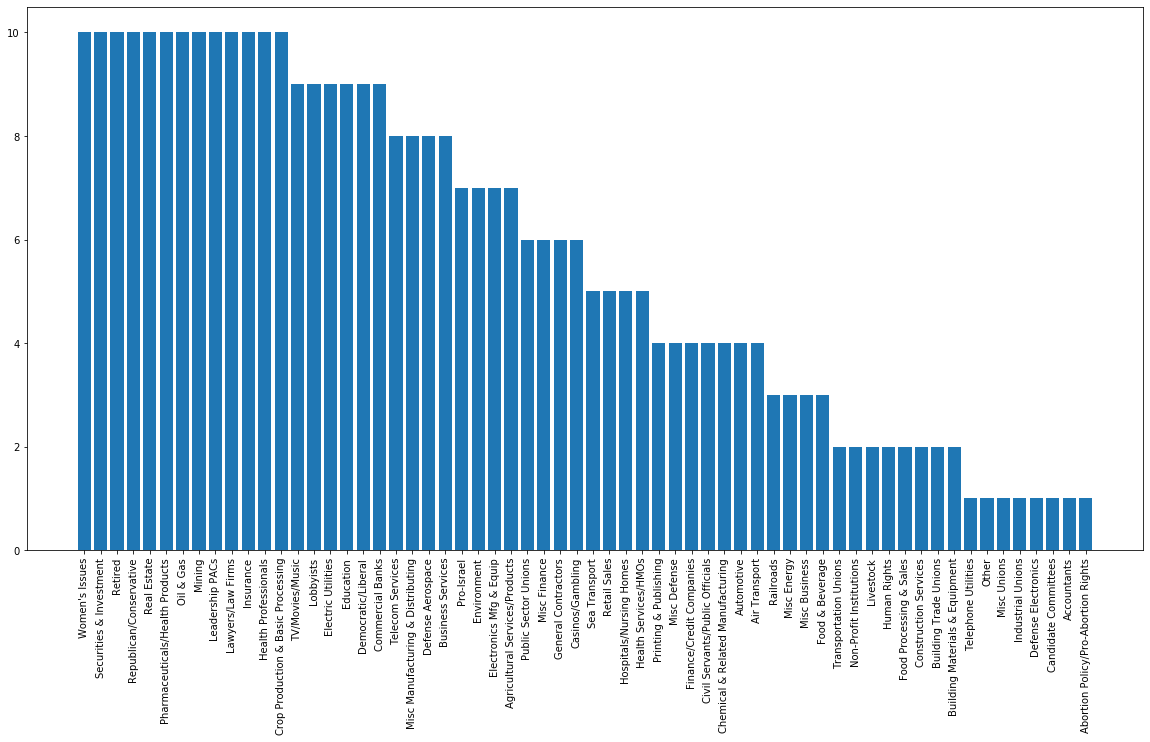

In [39]:
count_industry = []
for i in sorted(set(industries)):
    count_industry.append((industries.count(i), i))
    
sorted(count_industry)

x = [x[1] for x in sorted(count_industry, reverse=True)]
y = [x[0] for x in sorted(count_industry, reverse=True)]

plt.figure(figsize=(20,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [49]:
pd.DataFrame(sorted(count_industry, reverse=True)).to_csv('industry_dictionary.csv', index=False)

## Bills

In [26]:
bill_cong_to_search = []
for i in range(start_congress, current_congress+1):
    temp_bill = vmr_id_df[vmr_id_df['congress'] == i].bill_number.unique()
    temp_cong_bill = []
    for bill in temp_bill:
        temp_cong_bill.append([i, bill])
        
    bill_cong_to_search = bill_cong_to_search + temp_cong_bill

In [28]:
list_of_bill_info = []

for cong,bill in bill_cong_to_search:
    #get bill subjects
    try:
        with open('pro_pub_jsons/{}-{}_bill_sub.json'.format(bill.lower(), cong), 'r') as f:
            subjects = json.load(f)
    except:
        subjects = {bill: 'No subject file'}
    
    #get bill summary
    try:
        with open('pro_pub_jsons/{}-{}_bill_sum.json'.format(bill.lower(), cong), 'r') as f:
            summary = json.load(f)
    except:
        summary = {bill: 'No subject file'}

    #init the dictionary to store bill summary and subjects
    bill_dict = {'bill': bill,
                 'cong': cong}
    
    #
    for i in range(20):
        try:
            bill_dict.update({'subject_{}'.format(i): subjects['subjects'][i]['name']})
        except:
            bill_dict.update({'subject_{}'.format(i): np.nan})
        
    try:
        bill_dict.update({'bill_sum': summary['summary']})
    except:
        bill_dict.update({'bill_sum': np.nan})

    list_of_bill_info.append(bill_dict)
    
bill_info_df = pd.DataFrame(list_of_bill_info)

display(bill_info_df.head())
display(bill_info_df.tail())
display(bill_info_df.info())

,bill,cong,subject_0,subject_1,subject_2,subject_3,subject_4,subject_5,subject_6,subject_7,...,subject_11,subject_12,subject_13,subject_14,subject_15,subject_16,subject_17,subject_18,subject_19,bill_sum
0,SRES15,113,Congress,Federal officials,Judges,Senate,Legislative rules and procedure,Federal district courts,Congress,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(This measure has not been amended since it wa...
1,SRES16,113,Congress,Senate,Legislative rules and procedure,Congress,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(This measure has not been amended since it wa...
2,HR152,113,Emergency management,Appropriations,Army Corps of Engineers,Aviation and airports,Cemeteries and funerals,Coast guard,Computers and information technology,Congressional oversight,...,Department of Homeland Security,Department of Housing and Urban Development,Department of Transportation,Department of Veterans Affairs,Department of the Interior,Disaster relief and insurance,Economic development,Education programs funding,Emergency medical services and trauma care,(This measure has not been amended since it wa...
3,HR325,113,Congressional oversight,Members of Congress,Budget process,Economics and public finance,Budget deficits and national debt,"Government employee pay, benefits, personnel m...",Economics and Public Finance,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(This measure has not been amended since it wa...
4,S47,113,Alaska,Elementary and secondary education,Congressional oversight,Human rights,Higher education,Crime prevention,Child health,Crimes against women,...,Department of Health and Human Services,Public housing,Right of privacy,Northern Mariana Islands,Detention of persons,Medical education,Medical research,School administration,Family services,(This measure has not been amended since it wa...


,bill,cong,subject_0,subject_1,subject_2,subject_3,subject_4,subject_5,subject_6,subject_7,...,subject_11,subject_12,subject_13,subject_14,subject_15,subject_16,subject_17,subject_18,subject_19,bill_sum
251,HR6074,116,Congressional oversight,Appropriations,Department of State,Department of Health and Human Services,Medicare,Small business,World health,Medical research,...,Food and Drug Administration (FDA),"Diplomacy, foreign officials, Americans abroad",Foreign aid and international relief,Health,Health personnel,Health programs administration and funding,Executive agency funding and structure,Government lending and loan guarantees,Infectious and parasitic diseases,Coronavirus Preparedness and Response Suppleme...
252,SJRES56,116,Congressional oversight,Higher education,Department of Education,Educational facilities and institutions,Student aid and college costs,Administrative law and regulatory procedures,Government lending and loan guarantees,"Alternative dispute resolution, mediation, arb...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This joint resolution nullifies a rule issued ...
253,HJRES76,116,Congressional oversight,Higher education,Department of Education,Educational facilities and institutions,Student aid and college costs,Administrative law and regulatory procedures,Government lending and loan guarantees,"Alternative dispute resolution, mediation, arb...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This joint resolution nullifies a rule issued ...
254,HR6201,116,Elementary and secondary education,Child health,Women's health,Appropriations,Department of Health and Human Services,Medicaid,Medicare,Veterans' medical care,...,Mental health,Military medicine,Minority health,Adult day care,Aging,Social Security Administration,Indian social and development programs,Food assistance and relief,Health,Families First Coronavirus Response Act This b...
255,HR748,116,Taxation,Elementary and secondary education,Congressional agencies,Congressional oversight,Higher education,Economic development,Government trust funds,Child health,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   bill        256 non-null    object
 1   cong        256 non-null    int64 
 2   subject_0   245 non-null    object
 3   subject_1   237 non-null    object
 4   subject_2   237 non-null    object
 5   subject_3   234 non-null    object
 6   subject_4   229 non-null    object
 7   subject_5   221 non-null    object
 8   subject_6   207 non-null    object
 9   subject_7   191 non-null    object
 10  subject_8   172 non-null    object
 11  subject_9   159 non-null    object
 12  subject_10  151 non-null    object
 13  subject_11  148 non-null    object
 14  subject_12  141 non-null    object
 15  subject_13  134 non-null    object
 16  subject_14  131 non-null    object
 17  subject_15  123 non-null    object
 18  subject_16  119 non-null    object
 19  subject_17  116 non-null    object
 20  subject_18

None

In [43]:
subjects = []
for i in range(20):
    temp_sub = bill_info_df['subject_{}'.format(i)].unique()
    subjects += list(temp_sub)
    
subjects = [x for x in subjects if pd.notna(x)]   
set(subjects)

{'Abortion',
 'Academic performance and assessments',
 'Accidents',
 'Accounting and auditing',
 'Administrative law and regulatory procedures',
 'Administrative remedies',
 'Adult day care',
 'Advanced technology and technological innovations',
 'Advisory bodies',
 'Afghanistan',
 'Africa',
 'Age discrimination',
 'Aging',
 'Agricultural conservation and pollution',
 'Agricultural education',
 'Agricultural insurance',
 'Agricultural practices and innovations',
 'Agricultural research',
 'Agriculture and Food',
 'Air quality',
 'Alabama',
 'Alaska',
 'Alaska Natives and Hawaiians',
 'Albania',
 'Alcoholic beverages',
 'Alliances',
 'Allied health services',
 'Alternative and renewable resources',
 'Alternative dispute resolution, mediation, arbitration',
 'American Samoa',
 'Appropriations',
 'Aquaculture',
 'Aquatic ecology',
 'Arab-Israeli relations',
 'Architect of the Capitol',
 'Arizona',
 'Armed Forces and National Security',
 'Arms control and nonproliferation',
 'Army Corps of

In [44]:
len(set(subjects))

571

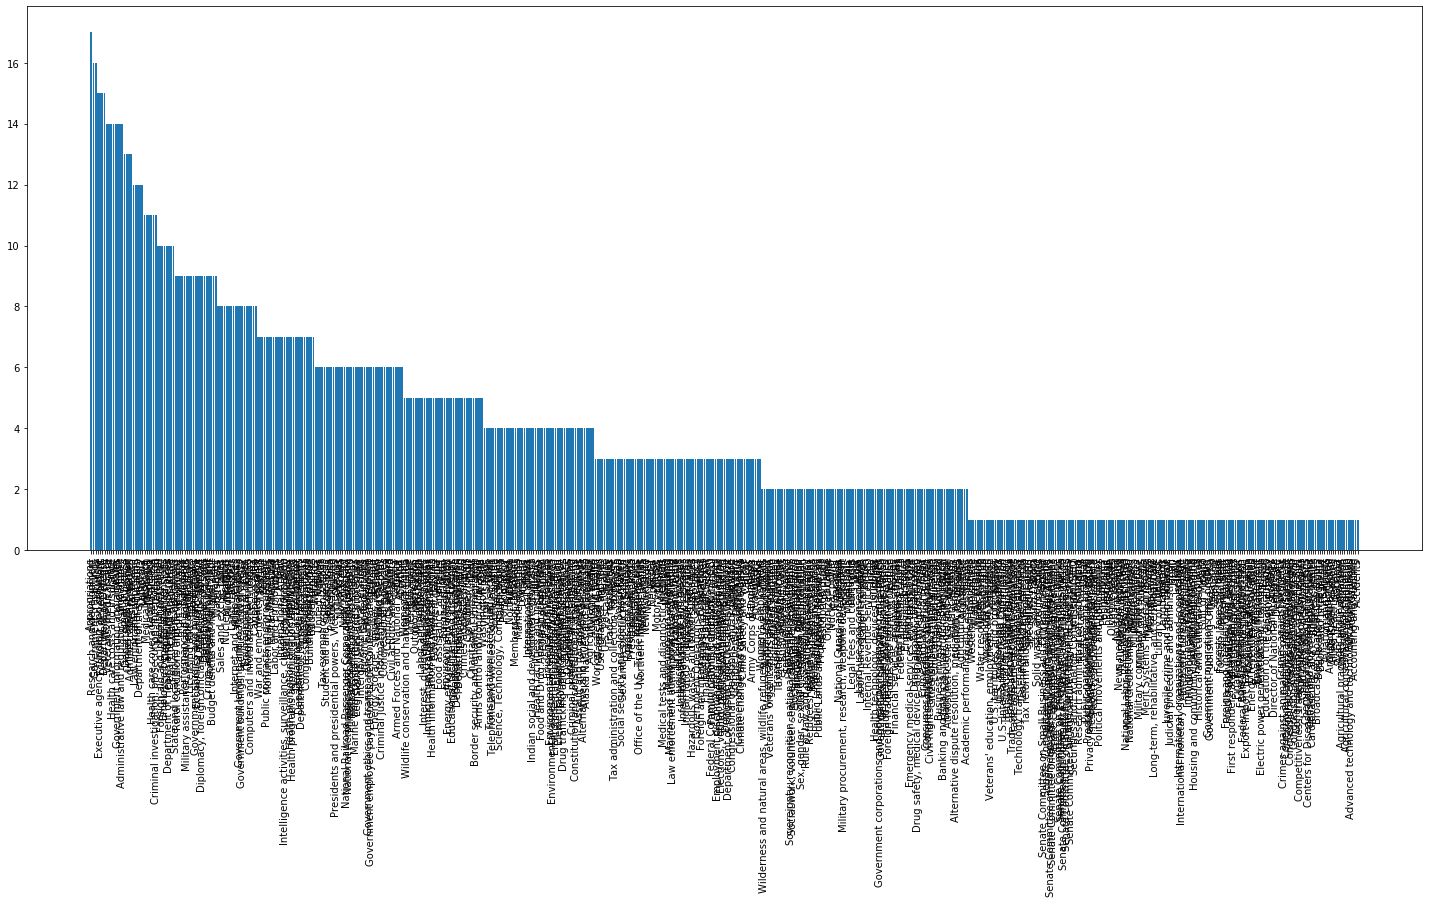

In [45]:
count_subject = []
for i in sorted(set(subjects)):
    count_subject.append((subjects.count(i), i))
    
sorted(count_subject)

x = [x[1] for x in sorted(count_subject, reverse=True)]
y = [x[0] for x in sorted(count_subject, reverse=True)]

plt.figure(figsize=(25,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [48]:
pd.DataFrame(sorted(count_subject, reverse=True)).to_csv('bill_subject_dictionary.csv', index=False)

## Bills and Industries to Larger DF

In [33]:
vmr_id_bill_df = vmr_id_df.merge(bill_info_df, how='left', 
                                 left_on=['congress', 'bill_number'],
                                 right_on=['cong', 'bill'])

vmr_id_bill_df.drop(['cong', 'bill'], axis=1, inplace=True)

display(vmr_id_bill_df.tail())
display(vmr_id_bill_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,subject_11,subject_12,subject_13,subject_14,subject_15,subject_16,subject_17,subject_18,subject_19,bill_sum
115646,116,Senate,508,49300,1,CA,"FEINSTEIN, Dianne",F000062,1933,-0.268,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."
115647,116,Senate,508,49308,1,WA,"MURRAY, Patty",M001111,1950,-0.350,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."
115648,116,Senate,508,49703,1,ME,"COLLINS, Susan Margaret",C001035,1952,0.112,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."
115649,116,Senate,508,49706,1,WY,"ENZI, Michael B.",E000285,1944,0.544,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."
115650,116,Senate,508,94659,1,AL,"SHELBY, Richard C.",S000320,1934,0.428,...,Performing arts,Appropriations,Department of Defense,Department of State,District of Columbia,Administrative remedies,Department of Health and Human Services,Medicaid,Medicare,"Coronavirus Aid, Relief, and Economic Securit..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115651 entries, 0 to 115650
Data columns (total 44 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   congress       115651 non-null  int64  
 1   chamber        115651 non-null  object 
 2   rollnumber     115651 non-null  int64  
 3   icpsr          115651 non-null  int64  
 4   cast_code      115651 non-null  int64  
 5   state_abbrev   115651 non-null  object 
 6   bioname        115651 non-null  object 
 7   bioguide_id    115651 non-null  object 
 8   born           115651 non-null  int64  
 9   nominate_dim1  115651 non-null  float64
 10  nominate_dim2  115651 non-null  float64
 11  party          115651 non-null  object 
 12  last_name      115651 non-null  object 
 13  first_name     115651 non-null  object 
 14  date           115651 non-null  object 
 15  session        115651 non-null  int64  
 16  yea_count      115651 non-null  int64  
 17  nay_count      115651 non-nul

None

In [52]:
vmr_id_bill_industry_df = vmr_id_bill_df.merge(industry_info_df, how='left', 
                                               left_on=['congress', 'cid'], 
                                               right_on=['cong', 'cid'])

vmr_id_bill_industry_df['campaign_year'] = vmr_id_bill_industry_df['congress'].apply(lambda x: int(cong_reference[x]))
vmr_id_bill_industry_df.drop('cong', axis=1, inplace=True)

display(vmr_id_bill_industry_df.head())
display(vmr_id_bill_industry_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,Industry_5_contrib,Industry_6,Industry_6_contrib,Industry_7,Industry_7_contrib,Industry_8,Industry_8_contrib,Industry_9,Industry_9_contrib,campaign_year
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,87156,Defense Aerospace,76800,Leadership PACs,71800,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,553218,Pharmaceuticals/Health Products,528432,Hospitals/Nursing Homes,458968,Real Estate,458830,Electric Utilities,287642,2012
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,219650,Lawyers/Law Firms,214173,Health Services/HMOs,214150,Retired,208157,Hospitals/Nursing Homes,204837,2012
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,288663,Hospitals/Nursing Homes,234500,Crop Production & Basic Processing,209235,Real Estate,203750,Insurance,183030,2012
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,128000,Public Sector Unions,94000,Retired,87100,Pro-Israel,76562,Real Estate,74900,2012


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115651 entries, 0 to 115650
Data columns (total 65 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   congress            115651 non-null  int64  
 1   chamber             115651 non-null  object 
 2   rollnumber          115651 non-null  int64  
 3   icpsr               115651 non-null  int64  
 4   cast_code           115651 non-null  int64  
 5   state_abbrev        115651 non-null  object 
 6   bioname             115651 non-null  object 
 7   bioguide_id         115651 non-null  object 
 8   born                115651 non-null  int64  
 9   nominate_dim1       115651 non-null  float64
 10  nominate_dim2       115651 non-null  float64
 11  party               115651 non-null  object 
 12  last_name           115651 non-null  object 
 13  first_name          115651 non-null  object 
 14  date                115651 non-null  object 
 15  session             115651 non-nul

None

In [53]:
cols_to_use = ['year', 'state_po', 'candidate', 'party', 'candidatevotes', 'totalvotes']
election_df = pd.read_csv('1976-2018-senate.csv', engine='python', usecols=cols_to_use)

election_df.dropna(inplace=True)

display(election_df.head(10))
display(election_df.info())

,year,state_po,candidate,party,candidatevotes,totalvotes
0,1976,AZ,Sam Steiger,republican,321236,741210
1,1976,AZ,Wm. Mathews Feighan,independent,1565,741210
2,1976,AZ,Dennis DeConcini,democrat,400334,741210
3,1976,AZ,Allan Norwitz,libertarian,7310,741210
4,1976,AZ,Bob Field,independent,10765,741210
5,1976,CA,Jack McCoy,american independent,82739,7470586
6,1976,CA,S. I. (Sam) Hayakawa,republican,3748973,7470586
7,1976,CA,John V. Tunney,democrat,3502862,7470586
8,1976,CA,Omari Musa,independent,31629,7470586
9,1976,CA,David Wald,peace and freedom,104383,7470586


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2858 entries, 0 to 3419
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            2858 non-null   int64 
 1   state_po        2858 non-null   object
 2   candidate       2858 non-null   object
 3   party           2858 non-null   object
 4   candidatevotes  2858 non-null   int64 
 5   totalvotes      2858 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 156.3+ KB


None

In [54]:
election_win_df = election_df.loc[election_df.groupby(['year','state_po']).candidatevotes.idxmax().values]

#fix Lisa Murkowski's nan value for the 2010 election
election_win_df.loc[election_win_df['candidate'] == 'Lisa Murkowski', 'party'] = 'republican'

#clean up party affiliations
election_win_df['party'] = election_win_df['party'].apply(lambda x: clean_election_history_parties(x))

#parse out first and last names
election_win_df['last_name'] = election_win_df['candidate'].apply(lambda x: parse_election_history_names(x, 'last'))
election_win_df['first_name'] = election_win_df['candidate'].apply(lambda x: parse_election_history_names(x, 'first'))

#calc how close the race was
election_win_df['percent_total_vote'] = round(election_win_df['candidatevotes'] / election_win_df['totalvotes'], 4)

election_win_df.reset_index(drop=True, inplace=True)

display(election_win_df.head())
display(election_win_df.info())

,year,state_po,candidate,party,candidatevotes,totalvotes,last_name,first_name,percent_total_vote
0,1976,AZ,Dennis DeConcini,D,400334,741210,DeConcini,Dennis,0.5401
1,1976,CA,S. I. (Sam) Hayakawa,R,3748973,7470586,Hayakawa,Sam,0.5018
2,1976,CT,"Lowell P. Weicker, Jr.",R,785683,1361666,Weicker,Lowell,0.5770
3,1976,DE,"William V. Roth, Jr.",R,125454,224795,Roth,William,0.5581
4,1976,FL,Lawton Chiles,D,1799518,2857534,Chiles,Lawton,0.6297


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                740 non-null    int64  
 1   state_po            740 non-null    object 
 2   candidate           740 non-null    object 
 3   party               740 non-null    object 
 4   candidatevotes      740 non-null    int64  
 5   totalvotes          740 non-null    int64  
 6   last_name           740 non-null    object 
 7   first_name          740 non-null    object 
 8   percent_total_vote  740 non-null    float64
dtypes: float64(1), int64(3), object(5)
memory usage: 52.2+ KB


None

In [55]:
first_elections = election_win_df.drop_duplicates(['state_po', 'last_name', 'first_name'], keep='first').copy()

cols_to_drop = ['candidate', 'party', 'candidatevotes', 'totalvotes', 'percent_total_vote']
first_elections.drop(cols_to_drop, axis=1, inplace=True)

first_elections.rename({'year': 'first_year_elected'}, axis=1, inplace=True)

display(first_elections.head())
display(first_elections.info())

,first_year_elected,state_po,last_name,first_name
0,1976,AZ,DeConcini,Dennis
1,1976,CA,Hayakawa,Sam
2,1976,CT,Weicker,Lowell
3,1976,DE,Roth,William
4,1976,FL,Chiles,Lawton


<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 733
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   first_year_elected  311 non-null    int64 
 1   state_po            311 non-null    object
 2   last_name           311 non-null    object
 3   first_name          311 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.1+ KB


None

In [56]:
elections_win_first_df = election_win_df.merge(first_elections, how='left', 
                                               on=['state_po', 'last_name', 'first_name'])

cols_to_drop = ['candidate', 'party', 'candidatevotes', 'totalvotes']
elections_win_first_df.drop(cols_to_drop, axis=1, inplace=True)

display(elections_win_first_df.head())
display(elections_win_first_df.tail())
display(elections_win_first_df.info())

,year,state_po,last_name,first_name,percent_total_vote,first_year_elected
0,1976,AZ,DeConcini,Dennis,0.5401,1976
1,1976,CA,Hayakawa,Sam,0.5018,1976
2,1976,CT,Weicker,Lowell,0.5770,1976
3,1976,DE,Roth,William,0.5581,1976
4,1976,FL,Chiles,Lawton,0.6297,1976


,year,state_po,last_name,first_name,percent_total_vote,first_year_elected
735,2018,VT,Sanders,Bernard,0.6732,2006
736,2018,WA,Cantwell,Maria,0.5843,2000
737,2018,WI,Baldwin,Tammy,0.5542,2012
738,2018,WV,Manchin,Joseph,0.4955,2010
739,2018,WY,Barrasso,John,0.6696,2012


<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 0 to 739
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                740 non-null    int64  
 1   state_po            740 non-null    object 
 2   last_name           740 non-null    object 
 3   first_name          740 non-null    object 
 4   percent_total_vote  740 non-null    float64
 5   first_year_elected  740 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 40.5+ KB


None

In [62]:
elections_win_first_df[elections_win_first_df['last_name'] == 'Cochran']

,year,state_po,last_name,first_name,percent_total_vote,first_year_elected
49,1978,MS,Cochran,Thad,0.4529,1978
148,1984,MS,Cochran,Thad,0.6094,1978
250,1990,MS,Cochran,Thad,1.0000,1978
351,1996,MS,Cochran,Thad,0.7103,1978
453,2002,MS,Cochran,Thad,0.8458,1978
553,2008,MS,Cochran,Thad,0.6144,1978
656,2014,MS,Cochran,Thad,0.5990,1978


In [65]:
main_df = vmr_id_bill_industry_df.merge(elections_win_first_df, how='left',
                                        left_on=['state_abbrev', 'last_name'],
                                        right_on=['state_po', 'last_name'])

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,Industry_8,Industry_8_contrib,Industry_9,Industry_9_contrib,campaign_year,year,state_po,first_name_y,percent_total_vote,first_year_elected
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012,1978.0,MS,Thad,0.4529,1978.0
1,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012,1984.0,MS,Thad,0.6094,1978.0
2,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012,1990.0,MS,Thad,1.0000,1978.0
3,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012,1996.0,MS,Thad,0.7103,1978.0
4,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,Real Estate,66560,Pharmaceuticals/Health Products,62000,2012,2002.0,MS,Thad,0.8458,1978.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306261 entries, 0 to 306260
Data columns (total 70 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   congress            306261 non-null  int64  
 1   chamber             306261 non-null  object 
 2   rollnumber          306261 non-null  int64  
 3   icpsr               306261 non-null  int64  
 4   cast_code           306261 non-null  int64  
 5   state_abbrev        306261 non-null  object 
 6   bioname             306261 non-null  object 
 7   bioguide_id         306261 non-null  object 
 8   born                306261 non-null  int64  
 9   nominate_dim1       306261 non-null  float64
 10  nominate_dim2       306261 non-null  float64
 11  party               306261 non-null  object 
 12  last_name           306261 non-null  object 
 13  first_name_x        306261 non-null  object 
 14  date                306261 non-null  object 
 15  session             306261 non-nul

None

In [ ]:
df = df.merge(windows,on='company',how='left')
df = df[(df.date >= df.beg_date) & (df.date <= df.end_date)]df = df.merge(windows,on='company',how='left')
df = df[(df.date >= df.beg_date) & (df.date <= df.end_date)]